<a href="https://colab.research.google.com/github/s-jainr/deep-learning-sp23/blob/main/v2_Deep_Learning_Final_Project_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytreebank
import pytreebank
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Load the dataset from disk
dataset = pytreebank.load_sst("/path/to/sentiment/")

train_data = dataset['train']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = []
label_counts = defaultdict(int)
MAX_PER_LABEL = 200
NUM_CLASSES = 5

for tree in train_data:
  datapoint = tree.to_labeled_lines()[0]
  label = datapoint[0]
  
  if label_counts[label] < MAX_PER_LABEL:
    data.append(datapoint)
    label_counts[label] += 1

  if len(label_counts) == NUM_CLASSES and min(
      label_counts.items(), key=lambda a: a[1])[1] == MAX_PER_LABEL:
    break

label_counts

defaultdict(int, {3: 200, 4: 200, 2: 200, 1: 200, 0: 200})

In [ ]:
train_data = data

# Build the vocabulary
vocab = set()
for sentence in train_data:
    sentence = sentence[1]
    words = sentence.lower().split()
    for word in words:
        vocab.add(word)

# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab):
    word_to_index[word.lower()] = i
    index_to_word[i] = word.lower()

# Convert the sentences to sequences of word indices
train_sequences = []
for sentence in train_data:
    sentence = sentence[1]
    words = sentence.lower().split()
    sequence = [word_to_index[word.lower()] for word in words]
    train_sequences.append(sequence)

# Pad the sequences to a fixed length
max_length = max(len(sequence) for sequence in train_sequences)
train_sequences = np.array([sequence + [0]*(max_length-len(sequence)) for sequence in train_sequences])

# Convert the labels to one-hot vectors
train_labels = np.zeros((len(train_data), 5))
for i, sentence in enumerate(train_data):
    train_labels[i][sentence[0]] = 1

In [ ]:
counts = np.sum(train_labels, axis=0)

for i in range(len(counts)):
  print(f"sentences in class {i}: {counts[i]:.0f}")

sentences in class 0: 200
sentences in class 1: 200
sentences in class 2: 200
sentences in class 3: 200
sentences in class 4: 200


In [ ]:
train_x = []
for seq in train_sequences:
  matrix = []
  for encoding in seq:
    seq_hot = np.zeros(len(vocab))
    seq_hot[encoding] = 1
    matrix.append(seq_hot)
  train_x.append(matrix)

train_x = np.array(train_x)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_labels, test_size=0.2, random_state=47)

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM

# model = Sequential()
# model.add(LSTM(128, input_shape=(train_x.shape[-2], train_x.shape[-1])))
# model.add(Dense(len(vocab)))
# model.add(Dense(5, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 50, 32)            458912    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 64)            6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 128)            24704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 128)          

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

network_history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=1000, batch_size=32, callbacks = [es])

Epoch 1/1000
25/25 [==============================] - 4s 54ms/step - loss: 1.6135 - accuracy: 0.1925 - val_loss: 1.6096 - val_accuracy: 0.2050
Epoch 2/1000
25/25 [==============================] - 1s 35ms/step - loss: 1.6033 - accuracy: 0.2575 - val_loss: 1.6130 - val_accuracy: 0.1550
Epoch 3/1000
25/25 [==============================] - 1s 42ms/step - loss: 1.5258 - accuracy: 0.3575 - val_loss: 1.6609 - val_accuracy: 0.2350
Epoch 4/1000
25/25 [==============================] - 1s 39ms/step - loss: 0.9192 - accuracy: 0.7250 - val_loss: 1.9267 - val_accuracy: 0.2450
Epoch 5/1000
25/25 [==============================] - 1s 49ms/step - loss: 0.2537 - accuracy: 0.9175 - val_loss: 2.8111 - val_accuracy: 0.2400
Epoch 6/1000
25/25 [==============================] - 1s 38ms/step - loss: 0.0783 - accuracy: 0.9862 - val_loss: 2.8810 - val_accuracy: 0.2400
Epoch 7/1000
25/25 [==============================] - 1s 44ms/step - loss: 0.0306 - accuracy: 0.9950 - val_loss: 3.3657 - val_accuracy: 0.2250

In [ ]:
model.evaluate(test_x, test_y)

7/7 [==============================] - 0s 19ms/step - loss: 4.1505 - accuracy: 0.2550


[4.150525093078613, 0.2549999952316284]

7/7 [==============================] - 0s 16ms/step


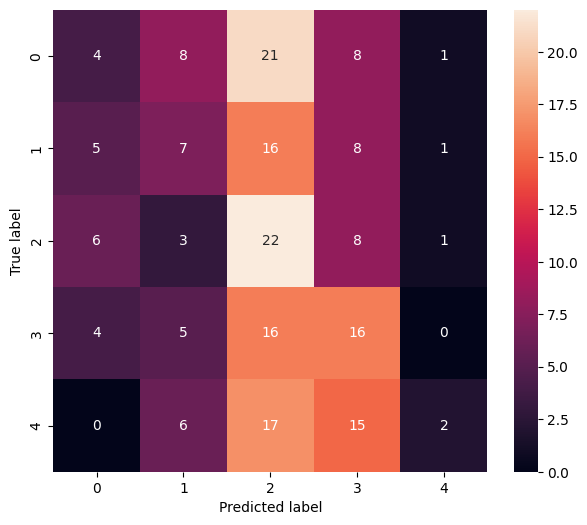

array([2, 2, 0, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2,
       3, 3, 2, 1, 1, 3, 2, 1, 2, 3, 3, 1, 0, 3, 2, 2, 2, 2, 3, 1, 2, 2,
       0, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 0,
       2, 1, 2, 3, 2, 3, 3, 1, 1, 3, 2, 3, 3, 3, 0, 0, 1, 4, 3, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 1, 2, 2, 2, 3, 2, 2, 3, 2,
       3, 4, 1, 2, 1, 2, 3, 3, 4, 2, 0, 0, 0, 3, 2, 1, 0, 3, 0, 2, 0, 1,
       2, 3, 3, 2, 1, 3, 0, 0, 0, 3, 3, 1, 3, 0, 2, 2, 2, 2, 2, 2, 3, 2,
       3, 3, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 4, 3, 2, 0, 2, 3, 3,
       2, 4, 2, 3, 3, 3, 2, 2, 3, 1, 3, 2, 2, 1, 1, 2, 1, 2, 0, 2, 3, 3,
       2, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
preds = model.predict(test_x)
conf = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(preds, axis=1))

# plot the confusion matrix as a heatmap
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

np.argmax(preds, axis=1)